In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subprocess
import os
from os import path
from datetime import datetime

### Same prompt (next 2 cells)

In [3]:
# Prompt user for manual or automated argument
while (True):
    dataset_type = str(input("Please enter 'manual', 'automated', or 'both' for the type of data set you are processing: "))
    # make case insenstive
    dataset_type = dataset_type.lower()
    if (dataset_type == "manual" or dataset_type == "automated" or dataset_type == 'both'):
        break
    print("Invalid argument")

Please enter 'manual', 'automated', or 'both' for the type of data set you are processing: automated


In [4]:
# Prompt user for type of analsyis
while (True):
    options = ["Bacillariophyceae", "Dinoflagellata", "Haptophyta",
               "other than diatoms dinoflagellates or haptophytes", "All", "All but other"]
    # Print out options
    for i in range(len(options)):
        print(str(i+1) + ":", options[i])
    analysis_type = int(input("Please enter a number (1-6) for the type analysis: "))
    if (analysis_type in range(1,7)):
        analysis_type = str(options[analysis_type-1])
        break
    print("Invalid argument")

1: Bacillariophyceae
2: Dinoflagellata
3: Haptophyta
4: other than diatoms dinoflagellates or haptophytes
5: All
6: All but other
Please enter a number (1-6) for the type analysis: 1


In [5]:
# # Ask user if running analysis on a new cruise
# while (True):
#     reply = str(input('Are you running the analysis on a new cruise? (y/n): ')).lower().strip()
#     if reply[0] == 'y':
#         break
#     if reply[0] == 'n':
#         break
#     else:
#         print("Please enter y/n")

In [6]:
# # first call bash script to get necessary file inputs
# # choose new_man_query_data.csv (60 samples) or man_query_data.csv (72 non-verified) 
# # as input file during file 1b construction, then intermediate_names_ids.csv for R prompts
# # only call if files don't exist or calling on new cruise data so program doesn't need to take full time to run
# if ( not reply[0] != 'y'):
#     # call bash script
#     subprocess.call(['./exec.sh', reply[0]])
#     import ifcb

In [7]:
# read different columns based on dataset type
if (dataset_type == 'manual'):
    columns = ['associatedMedia', 'data_provider_category_HumanObservation', 
               'higherClassification_group', 'scientificName_HumanObservation',
               'scientificNameID_HumanObservation', 'Biovolume']
elif (dataset_type == 'automated'):
    columns = ['associatedMedia', 'data_provider_category_MachineObservation']
else:
    columns = ['associatedMedia', 'data_provider_category_HumanObservation', 
               'data_provider_category_MachineObservation', 'higherClassification_group', 
               'scientificName_HumanObservation',
               'scientificNameID_HumanObservation', 'Biovolume']

In [8]:
# initialize data frame from input, should be able to start with level2 as well
sample_subset = pd.read_csv("../auto_join/level_1b.csv", usecols=columns)

### Matching code for next 5 cells

In [9]:
# get higher order data based on dataset
if (dataset_type == 'automated'):
    auto_taxon_info = pd.read_csv('../auto_join/resolved_auto.csv', 
                                  usecols=['name', 'resolved_names', 'resolved_higher_order_fromgnr', 'alt_datasource'])
    # merge to get taxa data
    sample_subset = pd.merge(sample_subset, auto_taxon_info, how='left', left_on='data_provider_category_MachineObservation', right_on='name')
    # rename resolved_higher_order column to match
    sample_subset.rename(columns={'resolved_higher_order_fromgnr':'higherClassification_group_automated'}, inplace=True)
elif (dataset_type == 'manual'):
    man_taxon_info = pd.read_csv('../auto_join/resolved_manual_matched_matchIDs_LOOKUPsorted.csv', 
                                  usecols=['name', 'resolved_names', 'alt_datasource'])
    # merge to get taxa data
    sample_subset = pd.merge(sample_subset, man_taxon_info, how='left', left_on='data_provider_category_HumanObservation', right_on='name')
    sample_subset.rename(columns={'higherClassification_group':'higherClassification_group_manual'}, inplace=True)
else:
    auto_taxon_info = pd.read_csv('../auto_join/resolved_auto.csv', 
                                  usecols=['name', 'resolved_names', 'resolved_higher_order_fromgnr', 'alt_datasource'])
    # merge to get taxa data
    sample_subset = pd.merge(sample_subset, auto_taxon_info, how='left', left_on='data_provider_category_MachineObservation', right_on='name')
    # rename resolved_higher_order column to match
    sample_subset.rename(columns={'resolved_higher_order_fromgnr':'higherClassification_group_automated', 
                           'higherClassification_group':'higherClassification_group_manual'}, 
                   inplace=True)
    man_taxon_info = pd.read_csv('../auto_join/resolved_manual_matched_matchIDs_LOOKUPsorted.csv', 
                                  usecols=['name', 'resolved_names'])
    # merge to get taxa data
    sample_subset = pd.concat([sample_subset, man_taxon_info], axis=1, sort=False)

In [10]:
# separate out roi id from associatedMedia
sample_subset['roi'] = sample_subset['associatedMedia']
sample_subset.roi = sample_subset.roi.str.slice(68, 74)
# gets rid of leading zeros
sample_subset.roi = sample_subset.roi.str.lstrip("0")
# cut associatedMedia to just be associatedMedia of sample
sample_subset.associatedMedia = sample_subset.associatedMedia.str.slice(0, 67)

In [11]:
# read in volume data
volumes = pd.read_csv("../volume/volumes.csv")
# merge with sample_subset
volumes.rename(columns={'permalink': 'associatedMedia'}, inplace=True)
sample_subset = pd.merge(sample_subset, volumes, how='left', on='associatedMedia')

In [12]:
# read in geolocation data
geo_data = pd.read_csv("geographic_subset.csv", usecols=['gps_furuno_latitude', 'gps_furuno_longitude', 
                                                         'date', 'pid'])
sample_subset = pd.merge(sample_subset, geo_data, how='left', left_on='associatedMedia', right_on='pid')
# get unique coordinates
unique_coords = sample_subset.groupby(['gps_furuno_latitude', 'gps_furuno_longitude', 'date']).size().reset_index().rename(columns={0:'count'})

In [13]:
# exclude abiotic particles from other
sample_subset = sample_subset[sample_subset['alt_datasource'] != 'OCB']
# include NotApplicable categories as other
if (dataset_type == 'manual'):
    sample_subset.higherClassification_group_manual[sample_subset['higherClassification_group_manual'] == 'NotApplicable'] = 'other than diatoms dinoflagellates or haptophytes'
elif (dataset_type == 'automated'):
    sample_subset.higherClassification_group_automated[sample_subset['higherClassification_group_automated'] == 'NotApplicable'] = 'other than diatoms dinoflagellates or haptophytes'
else:
    sample_subset.loc[sample_subset['higherClassification_group_manual'] == 'NotApplicable', 
                ['higherClassification_group_manual', 'higherClassification_group_automated']] = 'other than diatoms dinoflagellates or haptophytes'

In [14]:
# calculate abundance based on higher order and latitude
if (dataset_type == 'both'):
    # need 2 data frames for both
    auto_sample_subset = sample_subset.groupby(['gps_furuno_latitude', 'higherClassification_group_automated']).agg(
    {
        'roi': 'count',
        'volume_imaged': 'first',
        'gps_furuno_longitude': 'first'
    }
).reset_index()
    # manual data frame
    manual_sample_subset = sample_subset.groupby(['gps_furuno_latitude', 'higherClassification_group_manual']).agg(
    {
        'roi': 'count',
        'volume_imaged': 'first',
        'gps_furuno_longitude': 'first'
    }
).reset_index()
else:
    sample_subset = sample_subset.groupby(['gps_furuno_latitude', 'higherClassification_group_{}'.format(dataset_type)]).agg(
        {
            'roi': 'count',
            'volume_imaged': 'first',
            'date': 'first',
            'gps_furuno_longitude': 'first'
        }
    ).reset_index()

In [15]:
# calculate concentration from abundance and volume
if (dataset_type == 'both'):
    # calculate concentration for automated classifications
    auto_sample_subset['concentration'] = auto_sample_subset.roi/auto_sample_subset.volume_imaged
    # convert to float
    auto_sample_subset.concentration = auto_sample_subset.concentration.astype(float)
    # calculate concentrations for manual classifications
    manual_sample_subset['concentration'] = manual_sample_subset.roi/manual_sample_subset.volume_imaged
    # convert to float
    manual_sample_subset.concentration = manual_sample_subset.concentration.astype(float)
else:
    sample_subset['concentration'] = sample_subset.roi.astype(float)/sample_subset.volume_imaged.astype(float)
    # convert to float
    sample_subset.concentration = sample_subset.concentration.astype(float)

### Matching code for next 2 cells

In [16]:
# filter out to only read user specified analysis_type
if (dataset_type == 'both'):
    if (analysis_type == "All but other"):
        analysis_type = 'other than diatoms dinoflagellates or haptophytes'
        auto_sample_subset = auto_sample_subset[auto_sample_subset['higherClassification_group_automated'] != analysis_type].reset_index()
        manual_sample_subset = manual_sample_subset[manual_sample_subset['higherClassification_group_manual'] != analysis_type].reset_index()
    elif (analysis_type != 'All'):
        auto_sample_subset = auto_sample_subset[auto_sample_subset['higherClassification_group_automated'] == analysis_type].reset_index()
        manual_sample_subset = manual_sample_subset[manual_sample_subset['higherClassification_group_manual'] == analysis_type].reset_index()
else:
    if (analysis_type == "All but other"):
        analysis_type = 'other than diatoms dinoflagellates or haptophytes'
        sample_subset = sample_subset[sample_subset['higherClassification_group_{}'.format(dataset_type)] != analysis_type].reset_index()
    elif (analysis_type != 'All'):
        sample_subset = sample_subset[sample_subset['higherClassification_group_{}'.format(dataset_type)] == analysis_type].reset_index()

In [18]:
# pad with zeros if doesn't exist
if (dataset_type == 'both'):
    auto_sample_subset = auto_sample_subset.merge(unique_coords, how='right').reset_index()
    auto_sample_subset.higherClassification_group_automated = analysis_type
    auto_sample_subset.concentration[auto_sample_subset.concentration.isna()] = 0
    manual_sample_subset = manual_sample_subset.merge(unique_coords, how='right').reset_index()
    manual_sample_subset.higherClassification_group_manual = analysis_type
    manual_sample_subset.concentration[manual_sample_subset.concentration.isna()] = 0
    # get rid of these guys in manual- FAKE ZEROS
    remove = list(only_auto.gps_furuno_latitude)
    manual_sample_subset = manual_sample_subset[~manual_sample_subset['gps_furuno_latitude'].isin(remove)]
# here for auto/manual only 
else:
    # put stuff here
    sample_subset.merge(unique_coords, how='right', on="gps_furuno_latitude").reset_index()
    sample_subset.higherClassification_group_automated = analysis_type
    sample_subset.concentration[sample_subset.concentration.isna()] = 0
    # reset dates to be datetime objects
    sample_subset['date'] = sample_subset['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:00+00:00'))
    sample_subset = sample_subset.sort_values(by='date',ascending=True).reset_index()

/Users/Kathy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# check which dataset type
if (dataset_type == 'both'):
    # outer merge auto and manual to get sample_subset with only automated annotations
    auto_coords = auto_sample_subset[['gps_furuno_latitude', 'gps_furuno_longitude']]
    manual_coords = manual_sample_subset[['gps_furuno_latitude', 'higherClassification_group_manual']]
    only_auto = auto_coords.merge(manual_coords, how='left', on='gps_furuno_latitude')
    only_auto = only_auto[only_auto['higherClassification_group_manual'].isnull()].reset_index()
    # for map data (only temp)
    manual_sample_subset.to_csv(f"../../paper/manual_{analysis_type}.csv")
    auto_sample_subset.to_csv(f"../../paper/auto_{analysis_type}.csv")

In [19]:
# save output for map making
sample_subset.to_csv(f"auto_{analysis_type}.csv")

In [20]:
print("min: ", np.min(sample_subset.concentration))
print("max: ", np.max(sample_subset.concentration))

min:  19.56907853065459
max:  146.89398631181683


No handles with labels found to put in legend.


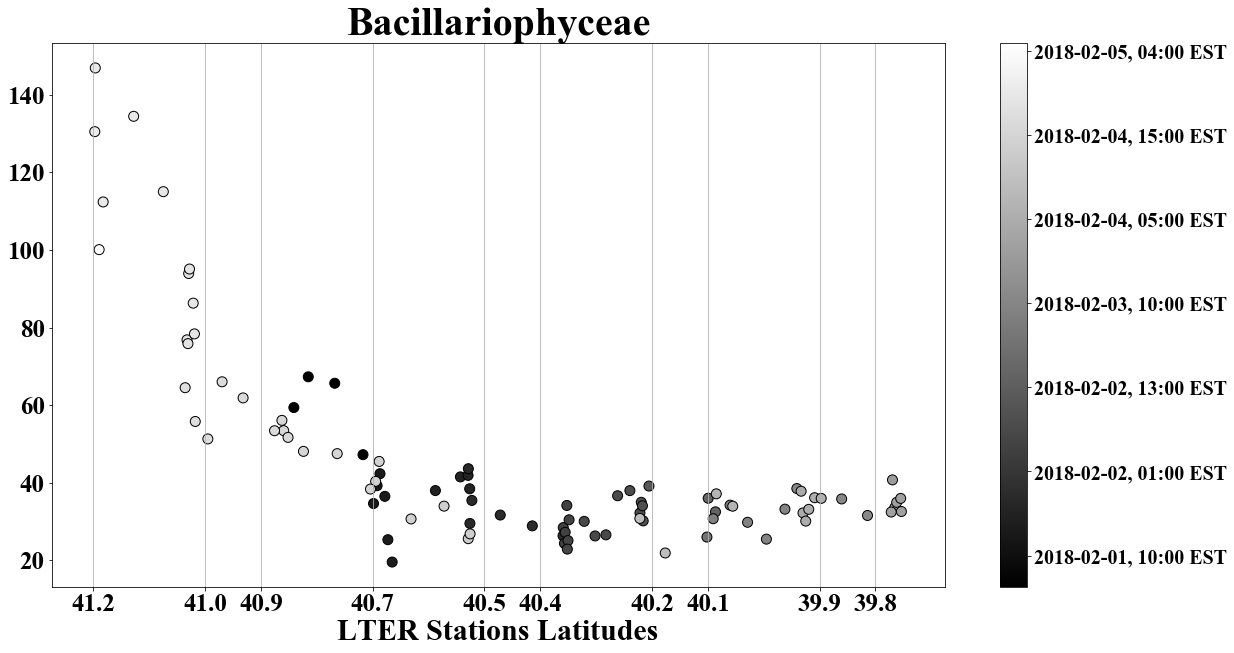

In [21]:
# take duplicate latitudes and add their concentrations together
fig, ax = plt.subplots(figsize=(20,10))
# use unstack()
if (dataset_type == 'both'):
    grouped = auto_sample_subset.groupby(['gps_furuno_latitude', 'higherClassification_group_automated']).sum()['concentration']
    grouped.unstack().plot(ax=ax, marker='o', markersize=10, label="Automated", linestyle='').grid(axis='x')
    grouped = manual_sample_subset.groupby(['gps_furuno_latitude', 'higherClassification_group_manual'.format(dataset_type)]).sum()['concentration']
    grouped.unstack().plot(ax=ax, marker='o', color='red', markersize=10, label="Manual", linestyle='').grid(axis='x')
    L=plt.legend(title=None, prop={"size":20, "family": "Times New Roman"})
    if (analysis_type != 'All'):
        L.get_texts()[0].set_text('automated')
        L.get_texts()[1].set_text('manual')
else:
    grouped = sample_subset.groupby(['gps_furuno_latitude', 'higherClassification_group_{}'.format(dataset_type)]).sum()['concentration']
    # grouped.unstack().plot(ax=ax, marker='o', markersize=10, linestyle='',c='black').grid(axis='x')
    sample_subset.plot.scatter(x='gps_furuno_latitude', y='concentration', 
                          ax=ax, marker='o', c=sample_subset.date, 
                          cmap='gray', edgecolors='black', s=100).grid(axis='x')
    # set color bar
    cb = ax.collections[-1].colorbar
    # stupid stupid color bar, sort indices first
    indices = [sample_subset.date[i] for i in np.linspace(0,grouped.shape[0]-1,7).astype(int)]
    cb.ax.set_yticklabels([index.strftime('%Y-%m-%d, %H:00 EST') for index in indices])
    cb.ax.tick_params(labelsize=20)
    # set stupid font
    for l in cb.ax.yaxis.get_ticklabels():
        l.set_family("Times New Roman")
# add titles and axes labels
plt.xlabel('LTER Stations Latitudes', size = 30, fontname="Times New Roman")
plt.ylabel('')
#plt.ylabel('Concentration (#/mL)', size = 25, fontname="Times New Roman")
plt.title(analysis_type, size = 40, fontname="Times New Roman")
# set stations as tick marks, separate into secondary xticks with labels
#labels=[41.1967, 41.03, 40.8633, 40.6967, 40.5133, 40.3633, 40.2267, 40.0983, 39.94, 39.7733]
labels=[41.2, 41.0, 40.9, 40.7, 40.5, 40.4, 40.2, 40.1, 39.9, 39.8]
ax.set_xticks(labels)
# invert x axis
ax.invert_xaxis()
ax.legend(title=None, prop={"size":20, "family": "Times New Roman"})
ax.get_legend().remove()
# plt.rcParams["font.family"] = "Times New Roman"
ax.tick_params(axis='both', which='major', labelsize=25)
# set tick marks font
for tick in ax.get_xticklabels():
    tick.set_fontname("Times New Roman")
for tick in ax.get_yticklabels():
    tick.set_fontname("Times New Roman")
fig = plt.gcf()
plt.show()

In [59]:
# Ask user if want to save graphs
while (True):
    reply = str(input('Save output? (y/n): ')).lower().strip()
    if reply[0] == 'y':
        fig.savefig(f'{analysis_type}_taxon_abundance.png', bbox_inches='tight')
        break
    if reply[0] == 'n':
        break
    else:
        print("Please enter y/n")

Save output? (y/n): y
